In [1]:
import pandas as pd
from pathlib import Path

In [2]:
data_path = Path.cwd().joinpath("datasets", "halifax_site", "output.json")

In [3]:
data_path.exists()

True

In [4]:
### Read file from json in pandas dataframe
halifax_text_df  = pd.read_json(data_path)

In [5]:
halifax_text_df["content"] = halifax_text_df.content.str.replace(
    r'\n{1,}', ' ', regex=True)

In [6]:
import re

In [7]:
halifax_text_df.content.drop_duplicates(keep="first")

0                     Everyday banking                 ...
1                           Everyday banking              
2         Banking online Banking online Download our Mo...
3         Banking online Download our Mobile Banking ap...
5         Mobile Banking app Mobile Banking app Setting...
                               ...                        
26165     What is gazundering? Gazundering is when, aft...
26168     How can you avoid being gazumped? There’s no ...
26169     Get a mortgage Agreement in Principle first S...
26170     Be prepared Get all the documents you’ll need...
26171     Ask for the property to be taken off the mark...
Name: content, Length: 1686, dtype: object

In [8]:
halifax_text_df = halifax_text_df[~halifax_text_df.content.duplicated()]

In [9]:
halifax_text_df.head(10)

,title,content,url
0,Everyday banking,Everyday banking ...,https://www.halifax.co.uk/mortgages/help-and-a...
1,Everyday banking,Everyday banking,https://www.halifax.co.uk/mortgages/help-and-a...
2,Banking online,Banking online Banking online Download our Mo...,https://www.halifax.co.uk/mortgages/help-and-a...
3,Banking online,Banking online Download our Mobile Banking ap...,https://www.halifax.co.uk/mortgages/help-and-a...
5,Mobile Banking app,Mobile Banking app Mobile Banking app Setting...,https://www.halifax.co.uk/mortgages/help-and-a...
6,Mobile Banking app,Mobile Banking app Setting up the app Biometr...,https://www.halifax.co.uk/mortgages/help-and-a...
8,Banking near you,Banking near you Banking near you,https://www.halifax.co.uk/mortgages/help-and-a...
9,Banking near you,Banking near you,https://www.halifax.co.uk/mortgages/help-and-a...
10,Profile & settings,Profile & settings Profile & settings Change ...,https://www.halifax.co.uk/mortgages/help-and-a...
11,Profile & settings,Profile & settings Change your telephone numb...,https://www.halifax.co.uk/mortgages/help-and-a...


In [10]:
halifax_text_df.title.loc[halifax_text_df.title.str.endswith("?")].drop_duplicates(keep="first")

42                                   Already bank with us?
55                              Already borrowing with us?
66                                        Already with us?
79                                 Already saving with us?
94                              Already investing with us?
                               ...                        
25059                     Ready to switch to solar energy?
26163                             How does gazumping work?
26164    What’s the difference between being outbid and...
26165                                 What is gazundering?
26168                    How can you avoid being gazumped?
Name: title, Length: 341, dtype: object

We don't have a huge dataset, most of our dataset is duplicated. However we have around 1686 data point we can work with! Most of those point may or may not be related to mortagage, but they will do the work.

In [11]:
halifax_text_df.head()

,title,content,url
0,Everyday banking,Everyday banking ...,https://www.halifax.co.uk/mortgages/help-and-a...
1,Everyday banking,Everyday banking,https://www.halifax.co.uk/mortgages/help-and-a...
2,Banking online,Banking online Banking online Download our Mo...,https://www.halifax.co.uk/mortgages/help-and-a...
3,Banking online,Banking online Download our Mobile Banking ap...,https://www.halifax.co.uk/mortgages/help-and-a...
5,Mobile Banking app,Mobile Banking app Mobile Banking app Setting...,https://www.halifax.co.uk/mortgages/help-and-a...


In [12]:
halifax_text_df

,title,content,url
0,Everyday banking,Everyday banking ...,https://www.halifax.co.uk/mortgages/help-and-a...
1,Everyday banking,Everyday banking,https://www.halifax.co.uk/mortgages/help-and-a...
2,Banking online,Banking online Banking online Download our Mo...,https://www.halifax.co.uk/mortgages/help-and-a...
3,Banking online,Banking online Download our Mobile Banking ap...,https://www.halifax.co.uk/mortgages/help-and-a...
5,Mobile Banking app,Mobile Banking app Mobile Banking app Setting...,https://www.halifax.co.uk/mortgages/help-and-a...
...,...,...,...
26165,What is gazundering?,"What is gazundering? Gazundering is when, aft...",https://www.halifax.co.uk/mortgages/help-and-a...
26168,How can you avoid being gazumped?,How can you avoid being gazumped? There’s no ...,https://www.halifax.co.uk/mortgages/help-and-a...
26169,Get a mortgage Agreement in Principle first,Get a mortgage Agreement in Principle first S...,https://www.halifax.co.uk/mortgages/help-and-a...
26170,Be prepared,Be prepared Get all the documents you’ll need...,https://www.halifax.co.uk/mortgages/help-and-a...


In [13]:
test_dataset = halifax_text_df.loc[halifax_text_df.title.loc[halifax_text_df.title.str.endswith(
    "?")].duplicated().index]

In [14]:
test_dataset = test_dataset.reset_index()

In [15]:
test_dataset["content_cleaned"] = test_dataset.apply(lambda x: x.content.replace(x.title, '').strip(), axis="columns")

In [16]:
test_dataset.iloc[1].content

'                 Already borrowing with us?                Existing credit card customers Existing loan customers Existing car finance customers Money worries Mobile banking Banking online Your Credit Score Thinking about applying for credit? Check Your Credit Score for free, with no impact on your credit file. Sign in to get started '

In [17]:
test_dataset.iloc[1].content

'                 Already borrowing with us?                Existing credit card customers Existing loan customers Existing car finance customers Money worries Mobile banking Banking online Your Credit Score Thinking about applying for credit? Check Your Credit Score for free, with no impact on your credit file. Sign in to get started '

In [18]:
test_dataset.iloc[1].content_cleaned

'Existing credit card customers Existing loan customers Existing car finance customers Money worries Mobile banking Banking online Your Credit Score Thinking about applying for credit? Check Your Credit Score for free, with no impact on your credit file. Sign in to get started'

In [19]:
test_dataset

,index,title,content,url,content_cleaned
0,42,Already bank with us?,Already bank with us? ...,https://www.halifax.co.uk/mortgages/help-and-a...,Upgrading your account Overdrafts Payments & t...
1,55,Already borrowing with us?,Already borrowing with us? ...,https://www.halifax.co.uk/mortgages/help-and-a...,Existing credit card customers Existing loan c...
2,66,Already with us?,Already with us? ...,https://www.halifax.co.uk/mortgages/help-and-a...,Existing customers Existing customers Manage y...
3,79,Already saving with us?,Already saving with us? ...,https://www.halifax.co.uk/mortgages/help-and-a...,Existing customers Manage your ISA Transfer yo...
4,94,Already investing with us?,Already investing with us? ...,https://www.halifax.co.uk/mortgages/help-and-a...,Sign in to Share Dealing Introducing the new R...
...,...,...,...,...,...
372,25059,Ready to switch to solar energy?,Ready to switch to solar energy? Getting sola...,https://www.halifax.co.uk/mortgages/help-and-a...,Getting solar energy in your home could lower ...
373,26163,How does gazumping work?,How does gazumping work? You’ve seen the hous...,https://www.halifax.co.uk/mortgages/help-and-a...,You’ve seen the house you want to buy. You’ve ...
374,26164,What’s the difference between being outbid and...,What’s the difference between being outbid an...,https://www.halifax.co.uk/mortgages/help-and-a...,The difference is that gazumping occurs when a...
375,26165,What is gazundering?,"What is gazundering? Gazundering is when, aft...",https://www.halifax.co.uk/mortgages/help-and-a...,"Gazundering is when, after the sale price has ..."


In [20]:
train_dataset = halifax_text_df.loc[~halifax_text_df.index.isin(test_dataset.index)]

In [21]:
train_dataset.head()

,title,content,url
990,First time buyer calculator,First time buyer calculator Looking to buy yo...,https://www.halifax.co.uk/mortgages/mortgage-c...
991,Home mover calculator,Home mover calculator Ready to move home? Use...,https://www.halifax.co.uk/mortgages/mortgage-c...
992,Remortgage calculator,Remortgage calculator Got a mortgage with a d...,https://www.halifax.co.uk/mortgages/mortgage-c...
993,Switching your mortgage,Switching your mortgage If your existing Hali...,https://www.halifax.co.uk/mortgages/mortgage-c...
994,Borrowing more calculator,Borrowing more calculator If you want to borr...,https://www.halifax.co.uk/mortgages/mortgage-c...


Now have our train and test dataset, we need to move to the next step step which involve, building the pipeline which will index the documeent in our vector database and then respond to the question.

train_datatset.shape

In [22]:
train_dataset.shape

(1561, 3)

In [23]:
train_dataset.sample(10)

,title,content,url
19519,How can I find out more information?,How can I find out more information? If you’d...,https://www.halifax.co.uk/mortgages/mortgage-p...
1681,The important bit...,The important bit... To qualify for the month...,https://www.halifax.co.uk/mortgages/mortgage-p...
5777,4. Apply for a mortgage,4. Apply for a mortgage Found something you l...,https://www.halifax.co.uk/mortgages/government...
16231,Think you might need to miss a payment?,Think you might need to miss a payment? Pleas...,https://www.halifax.co.uk/mortgages/existing-c...
9426,Repaying your mortgage whilst on maternity leave,Repaying your mortgage whilst on maternity le...,https://www.halifax.co.uk/mortgages/help-and-a...
2909,I arranged to switch to a new fixed rate produ...,I arranged to switch to a new fixed rate prod...,https://www.halifax.co.uk/mortgages/existing-c...
19772,Tips for keeping your deposit intact,Tips for keeping your deposit intact Take a v...,https://www.halifax.co.uk/mortgages/help-and-a...
5916,Telling your solicitor/conveyancer you are in ...,Telling your solicitor/conveyancer you are in...,https://www.halifax.co.uk/mortgages/help-and-a...
18754,Why choose Halifax?,Why choose Halifax? We've been helping people...,https://www.halifax.co.uk/mortgages/existing-c...
13176,Floor insulation\n ...,Floor insulation ...,https://www.halifax.co.uk/mortgages/help-and-a...


In [24]:
train_dataset.head()

,title,content,url
990,First time buyer calculator,First time buyer calculator Looking to buy yo...,https://www.halifax.co.uk/mortgages/mortgage-c...
991,Home mover calculator,Home mover calculator Ready to move home? Use...,https://www.halifax.co.uk/mortgages/mortgage-c...
992,Remortgage calculator,Remortgage calculator Got a mortgage with a d...,https://www.halifax.co.uk/mortgages/mortgage-c...
993,Switching your mortgage,Switching your mortgage If your existing Hali...,https://www.halifax.co.uk/mortgages/mortgage-c...
994,Borrowing more calculator,Borrowing more calculator If you want to borr...,https://www.halifax.co.uk/mortgages/mortgage-c...


In [25]:
train_dataset["content_cleaned"] = train_dataset.apply(lambda x: x.content.replace(x.title.strip(), '').strip(), axis="columns")
test_dataset["content_cleaned"] = test_dataset.apply(lambda x: x.content.replace(x.title.strip(), '').strip(), axis="columns")

/var/folders/ds/0g69mdw97cq_0bt80x0f_s240000gn/T/ipykernel_73062/2568209070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset["content_cleaned"] = train_dataset.apply(lambda x: x.content.replace(x.title.strip(), '').strip(), axis="columns")


In [26]:
train_dataset = train_dataset.loc[train_dataset.content_cleaned.str.len() != 0]

In [27]:
train_dataset.head()

,title,content,url,content_cleaned
990,First time buyer calculator,First time buyer calculator Looking to buy yo...,https://www.halifax.co.uk/mortgages/mortgage-c...,Looking to buy your first home? Use our mortga...
991,Home mover calculator,Home mover calculator Ready to move home? Use...,https://www.halifax.co.uk/mortgages/mortgage-c...,Ready to move home? Use our home mover calcula...
992,Remortgage calculator,Remortgage calculator Got a mortgage with a d...,https://www.halifax.co.uk/mortgages/mortgage-c...,Got a mortgage with a different provider? See ...
993,Switching your mortgage,Switching your mortgage If your existing Hali...,https://www.halifax.co.uk/mortgages/mortgage-c...,If your existing Halifax mortgage is coming to...
994,Borrowing more calculator,Borrowing more calculator If you want to borr...,https://www.halifax.co.uk/mortgages/mortgage-c...,"If you want to borrow more on your mortgage, y..."


Next we will be using the model  to encode the characters.



bitext/Mistral-7B-Mortgage-Loans

We will be using that model to learn the embeddings.

https://github.com/AI4Finance-Foundation/FinGPT?tab=readme-ov-file

GPT like models cannot generalize embedding well. need to find a good model to use to learn embedding.

dunzhang/stella_en_1.5B_v5

This will be best language model to use, it is small and match the quality.

Need to learn and find out what is the shape fo the models.


response

### Experiment with support for other models.

In [28]:
from sentence_transformers import SentenceTransformer

/Users/esp.py/Projects/Personal/end-to-end-rag/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [29]:
model_path = Path.cwd().joinpath("models")

In [30]:
model_id = "dunzhang/stella_en_400M_v5"

In [32]:
model = SentenceTransformer(
    model_path.joinpath(model_id).__str__(),
    trust_remote_code=True,
    device="cpu",
    config_kwargs={"use_memory_efficient_attention": False, "unpad_inputs": False},
    local_files_only=True
)

Some weights of the model checkpoint at /Users/esp.py/Projects/Personal/end-to-end-rag/models/dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
query_prompt_name = "s2p_query"
queries = [
    "What are some ways to reduce stress?",
    "What are the benefits of drinking green tea?",
    "How often do mortgage rates change?",
]
# docs do not need any prompts
docs = [
    "There are many effective ways to reduce stress. Some common techniques include deep breathing, meditation, and physical activity. Engaging in hobbies, spending time in nature, and connecting with loved ones can also help alleviate stress. Additionally, setting boundaries, practicing self-care, and learning to say no can prevent stress from building up.",
    "Green tea has been consumed for centuries and is known for its potential health benefits. It contains antioxidants that may help protect the body against damage caused by free radicals. Regular consumption of green tea has been associated with improved heart health, enhanced cognitive function, and a reduced risk of certain types of cancer. The polyphenols in green tea may also have anti-inflammatory and weight loss properties.",
    " Mortgage rates can stay the same for years or they can change often, depending on various factors and market conditions. Factors like the Bank of England Base Rate, the housing market and the state of the economy can affect mortgage rates. But if you have a fixed rate mortgage, your rate stays the same for the length of your deal.  If you’ve already applied for a Halifax mortgage, the rate we’ve offered you won’t be affected by any changes to our mortgage range once the mortgage illustration has been accepted. "
]

In [37]:
query_embeddings = model.encode(queries, prompt_name=query_prompt_name)
doc_embeddings = model.encode(docs)

/Users/esp.py/Projects/Personal/end-to-end-rag/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [38]:
similarities = model.similarity(query_embeddings, doc_embeddings)
print(similarities)

tensor([[0.8398, 0.2990, 0.2574],
        [0.3282, 0.8095, 0.1961],
        [0.2023, 0.1731, 0.7108]])


In [34]:
train_dataset.head()

,title,content,url,content_cleaned
990,First time buyer calculator,First time buyer calculator Looking to buy yo...,https://www.halifax.co.uk/mortgages/mortgage-c...,Looking to buy your first home? Use our mortga...
991,Home mover calculator,Home mover calculator Ready to move home? Use...,https://www.halifax.co.uk/mortgages/mortgage-c...,Ready to move home? Use our home mover calcula...
992,Remortgage calculator,Remortgage calculator Got a mortgage with a d...,https://www.halifax.co.uk/mortgages/mortgage-c...,Got a mortgage with a different provider? See ...
993,Switching your mortgage,Switching your mortgage If your existing Hali...,https://www.halifax.co.uk/mortgages/mortgage-c...,If your existing Halifax mortgage is coming to...
994,Borrowing more calculator,Borrowing more calculator If you want to borr...,https://www.halifax.co.uk/mortgages/mortgage-c...,"If you want to borrow more on your mortgage, y..."


In [35]:
train_dataset.head()

,title,content,url,content_cleaned
990,First time buyer calculator,First time buyer calculator Looking to buy yo...,https://www.halifax.co.uk/mortgages/mortgage-c...,Looking to buy your first home? Use our mortga...
991,Home mover calculator,Home mover calculator Ready to move home? Use...,https://www.halifax.co.uk/mortgages/mortgage-c...,Ready to move home? Use our home mover calcula...
992,Remortgage calculator,Remortgage calculator Got a mortgage with a d...,https://www.halifax.co.uk/mortgages/mortgage-c...,Got a mortgage with a different provider? See ...
993,Switching your mortgage,Switching your mortgage If your existing Hali...,https://www.halifax.co.uk/mortgages/mortgage-c...,If your existing Halifax mortgage is coming to...
994,Borrowing more calculator,Borrowing more calculator If you want to borr...,https://www.halifax.co.uk/mortgages/mortgage-c...,"If you want to borrow more on your mortgage, y..."


In [36]:
test_dataset.head()

,index,title,content,url,content_cleaned
0,42,Already bank with us?,Already bank with us? ...,https://www.halifax.co.uk/mortgages/help-and-a...,Upgrading your account Overdrafts Payments & t...
1,55,Already borrowing with us?,Already borrowing with us? ...,https://www.halifax.co.uk/mortgages/help-and-a...,Existing credit card customers Existing loan c...
2,66,Already with us?,Already with us? ...,https://www.halifax.co.uk/mortgages/help-and-a...,Existing customers Existing customers Manage y...
3,79,Already saving with us?,Already saving with us? ...,https://www.halifax.co.uk/mortgages/help-and-a...,Existing customers Manage your ISA Transfer yo...
4,94,Already investing with us?,Already investing with us? ...,https://www.halifax.co.uk/mortgages/help-and-a...,Sign in to Share Dealing Introducing the new R...


In [37]:
sample = train_dataset.sample(10)

In [38]:
sample_queries = sample["title"].tolist()
sample_docs = sample["content_cleaned"].tolist()

In [39]:
sample_queries_embeddings = model.encode(sample_queries, prompt_name=query_prompt_name)
sample_docs_embeddings = model.encode(sample_docs)

similarities = model.similarity(sample_queries_embeddings, sample_docs_embeddings)

/Users/esp.py/Projects/Personal/end-to-end-rag/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:1101: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [40]:
import seaborn as sb

<Axes: >

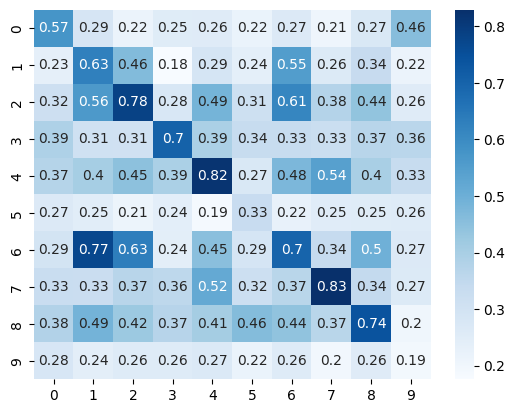

In [41]:
sb.heatmap(similarities, cmap="Blues", annot=True)

In [42]:
sample.iloc[4]

title                        How to work out the equity in your home
content             How to work out the equity in your home To wo...
url                https://www.halifax.co.uk/mortgages/help-and-a...
content_cleaned    To work out roughly how much equity you have i...
Name: 5857, dtype: object

We need to do more cleaning.

We can already ingest this document and train our rag on it.

The next stip will be to ingest the model in the database. and read from them.

training_set

In [43]:
train_dataset.head()

,title,content,url,content_cleaned
990,First time buyer calculator,First time buyer calculator Looking to buy yo...,https://www.halifax.co.uk/mortgages/mortgage-c...,Looking to buy your first home? Use our mortga...
991,Home mover calculator,Home mover calculator Ready to move home? Use...,https://www.halifax.co.uk/mortgages/mortgage-c...,Ready to move home? Use our home mover calcula...
992,Remortgage calculator,Remortgage calculator Got a mortgage with a d...,https://www.halifax.co.uk/mortgages/mortgage-c...,Got a mortgage with a different provider? See ...
993,Switching your mortgage,Switching your mortgage If your existing Hali...,https://www.halifax.co.uk/mortgages/mortgage-c...,If your existing Halifax mortgage is coming to...
994,Borrowing more calculator,Borrowing more calculator If you want to borr...,https://www.halifax.co.uk/mortgages/mortgage-c...,"If you want to borrow more on your mortgage, y..."


In [44]:
train_dataset = train_dataset[~train_dataset.content.isna()
                              & ~train_dataset.url.isna()]
test_dataset = test_dataset[~test_dataset.content.isna() & ~test_dataset.url.isna()]

In [45]:
dataset_path = Path.cwd().joinpath("datasets", "halifax_site")

In [50]:
train_dataset.to_csv(dataset_path.joinpath("training_data.csv"), sep="|", index=False)

In [51]:
test_dataset.to_csv(dataset_path.joinpath("test_data.csv"), sep="|", index=False)

In [52]:
from haystack.document_stores.types import DuplicatePolicy

In [48]:
train_dataset.head()

,title,content,url,content_cleaned
990,First time buyer calculator,First time buyer calculator Looking to buy yo...,https://www.halifax.co.uk/mortgages/mortgage-c...,Looking to buy your first home? Use our mortga...
991,Home mover calculator,Home mover calculator Ready to move home? Use...,https://www.halifax.co.uk/mortgages/mortgage-c...,Ready to move home? Use our home mover calcula...
992,Remortgage calculator,Remortgage calculator Got a mortgage with a d...,https://www.halifax.co.uk/mortgages/mortgage-c...,Got a mortgage with a different provider? See ...
993,Switching your mortgage,Switching your mortgage If your existing Hali...,https://www.halifax.co.uk/mortgages/mortgage-c...,If your existing Halifax mortgage is coming to...
994,Borrowing more calculator,Borrowing more calculator If you want to borr...,https://www.halifax.co.uk/mortgages/mortgage-c...,"If you want to borrow more on your mortgage, y..."


In [49]:
train_dataset.shape

(1442, 4)

tra